# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## IMPLEMENTING DIFFERENT MODELS 

In [31]:
# importing dependencies here
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

# code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [32]:
# reading the final datasets
personality_data = pd.read_csv("data_ekta/clean_data_3.csv")

<IPython.core.display.Javascript object>

In [33]:
# checking counts dataset
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,asked thing wish earlier find answering...,0.99980,0.414667,0.136150,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,love equally important music window soul in...,0.99995,0.596000,0.134585,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


<IPython.core.display.Javascript object>

### Setting predictors and target variable


In [34]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four targets is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


<IPython.core.display.Javascript object>

### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [35]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "stuff",
    "gift",
    "song",
    "world",
    "type",
]

<IPython.core.display.Javascript object>

### Setting up preprocessor for vectorization and selecting best counts and scores

In [36]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

### Modelling

In [121]:
# setting up the personality dictionary for printing scores
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}


from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import make_index_balanced_accuracy
from imblearn.metrics import sensitivity_specificity_support

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


# function to build the model for predicting each of 4 target features
def build_model(model, X, y, vectorizer_name):

    for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_proba = model.predict_proba(X_test)[:, 0]

        average_precision = average_precision_score(y_test, y_proba)

        #         print("Average precision-recall score: {0:0.2f}".format(average_precision))

        # model evaluation
        #         print(
        #             f"Accuracy: {model.geometric_mean_score(y_test, y_pred, average=None)} \n"
        #         )
        #         print(f"Accuracy: {model.score(y_test, y_pred)} \n")
        print(classification_report_imbalanced(y_test, y_pred))


#         disp = plot_precision_recall_curve(model, X_test, y_test)
#         disp.ax_.set_title(
#             "2-class Precision-Recall curve: " "AP={0:0.2f}".format(average_precision)
#         )

<IPython.core.display.Javascript object>

### TF-IDF Logistic Regression

In [122]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(cv=5)
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.70      0.65      0.77      0.67      0.45      1322
          1       0.39      0.65      0.70      0.49      0.67      0.45       396

avg / total       0.76      0.69      0.66      0.71      0.67      0.45      1718


Sensing vs Intuition
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.69      0.72      0.80      0.71      0.50      1481
          1       0.27      0.72      0.69      0.39      0.71      0.50       237

avg / total       0.85      0.69      0.72      0.74      0.71      0.50      1718


Thinking vs Feeling
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.78      0.79      0.80      0.78      0.61       929
          1       0.75      0.79      0.78      0.77      0.78      0.62       789

avg / total 

<IPython.core.display.Javascript object>

### Count Vectorized Logistic Regression

In [87]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.69      0.65      0.77      0.67      0.45      1322
          1       0.38      0.65      0.69      0.48      0.67      0.44       396

avg / total       0.76      0.68      0.66      0.70      0.67      0.45      1718

The geometric mean is 0.6676458677716186
[0.44743809 0.44406392]
(0.667914011522181, 0.667914011522181, None)

Sensing vs Intuition
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.64      0.73      0.76      0.68      0.46      1481
          1       0.24      0.73      0.64      0.36      0.68      0.47       237

avg / total       0.84      0.65      0.72      0.70      0.68      0.46      1718

The geometric mean is 0.6810298707947294
[0.45941522 0.46818815]
(0.6826696524471718, 0.6826696524471718, None)

Thinking vs Feeling
                   pre       rec       sp

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Lasso

In [10]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6507566938300349 

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1322
           1       0.35      0.61      0.45       396

    accuracy                           0.65      1718
   macro avg       0.60      0.64      0.60      1718
weighted avg       0.74      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6536670547147846 

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1481
           1       0.24      0.72      0.36       237

    accuracy                           0.65      1718
   macro avg       0.59      0.68      0.56      1718
weighted avg       0.84      0.65      0.71      1718


Thinking vs Feeling
Accuracy: 0.7683352735739232 

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       929
           1       0.74      0.77      0.75       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Lasso

In [11]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6589057043073341 

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      1322
           1       0.36      0.64      0.46       396

    accuracy                           0.66      1718
   macro avg       0.61      0.65      0.61      1718
weighted avg       0.75      0.66      0.68      1718


Sensing vs Intuition
Accuracy: 0.6338766006984866 

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1481
           1       0.22      0.65      0.33       237

    accuracy                           0.63      1718
   macro avg       0.57      0.64      0.54      1718
weighted avg       0.82      0.63      0.69      1718


Thinking vs Feeling
Accuracy: 0.7497089639115251 

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       929
           1       0.72      0.75      0.73       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Ridge

In [12]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6763678696158324 

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      1322
           1       0.39      0.68      0.49       396

    accuracy                           0.68      1718
   macro avg       0.63      0.68      0.63      1718
weighted avg       0.76      0.68      0.70      1718


Sensing vs Intuition
Accuracy: 0.6926658905704307 

              precision    recall  f1-score   support

           0       0.94      0.69      0.79      1481
           1       0.27      0.73      0.39       237

    accuracy                           0.69      1718
   macro avg       0.61      0.71      0.59      1718
weighted avg       0.85      0.69      0.74      1718


Thinking vs Feeling
Accuracy: 0.7863795110593713 

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       929
           1       0.75      0.79      0.77       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Ridge

In [13]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6542491268917345 

              precision    recall  f1-score   support

           0       0.85      0.66      0.75      1322
           1       0.36      0.62      0.45       396

    accuracy                           0.65      1718
   macro avg       0.61      0.64      0.60      1718
weighted avg       0.74      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6629802095459837 

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1481
           1       0.25      0.71      0.37       237

    accuracy                           0.66      1718
   macro avg       0.59      0.68      0.57      1718
weighted avg       0.84      0.66      0.71      1718


Thinking vs Feeling
Accuracy: 0.7747380675203726 

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       929
           1       0.74      0.78      0.76       789

    accuracy          

<IPython.core.display.Javascript object>

### TF-IDF Logistic Elasticnet

* Takes longest to run and the results are almost same as lasso and ridge model. So this code is commented to save time when re-running the entire notebook.

In [14]:
# %%time

# for col in y.columns:

#     print(f"\n{mbti_type[col]}")

#     target = y[col]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, target, test_size=0.2, random_state=42, stratify=target
#     )

#     tfidf_logistic_regression_elasticnet = imb_make_pipeline(
#         preprocesser_tf,
#     #     DenseTransformer(),
#         RandomUnderSampler(),
#         LogisticRegressionCV(
#             penalty='elasticnet',
#             l1_ratios=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
#             solver='saga'
#         )
#     )

#     tfidf_logistic_regression_elasticnet.fit(X_train, y_train)

#     print(f'Accuracy: {tfidf_logistic_regression_elasticnet.score(X_test, y_test)} \n')
#     print(classification_report(y_test, tfidf_logistic_regression_elasticnet.predict(X_test)))

<IPython.core.display.Javascript object>

### TF-IDF Support Vector Classifier

In [15]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), LinearSVC()
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6647264260768335 

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      1322
           1       0.37      0.67      0.48       396

    accuracy                           0.66      1718
   macro avg       0.62      0.67      0.62      1718
weighted avg       0.76      0.66      0.69      1718


Sensing vs Intuition
Accuracy: 0.6664726426076834 

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1481
           1       0.25      0.70      0.37       237

    accuracy                           0.67      1718
   macro avg       0.59      0.68      0.57      1718
weighted avg       0.84      0.67      0.72      1718


Thinking vs Feeling
Accuracy: 0.7718277066356228 

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       929
           1       0.74      0.77      0.76       789

    accuracy          

<IPython.core.display.Javascript object>

### Count Vectorized Support Vector Classifier

In [16]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), LinearSVC()
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6088474970896391 

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      1322
           1       0.32      0.60      0.42       396

    accuracy                           0.61      1718
   macro avg       0.58      0.61      0.56      1718
weighted avg       0.72      0.61      0.64      1718


Sensing vs Intuition
Accuracy: 0.6123399301513388 

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      1481
           1       0.20      0.62      0.31       237

    accuracy                           0.61      1718
   macro avg       0.56      0.62      0.52      1718
weighted avg       0.81      0.61      0.67      1718


Thinking vs Feeling
Accuracy: 0.7223515715948777 

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       929
           1       0.69      0.71      0.70       789

    accuracy          

<IPython.core.display.Javascript object>

### TF-IDF Naive Bayes

In [17]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6670547147846333 

              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1322
           1       0.38      0.74      0.51       396

    accuracy                           0.67      1718
   macro avg       0.64      0.69      0.63      1718
weighted avg       0.78      0.67      0.69      1718


Sensing vs Intuition
Accuracy: 0.640279394644936 

              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1481
           1       0.25      0.78      0.37       237

    accuracy                           0.64      1718
   macro avg       0.60      0.70      0.56      1718
weighted avg       0.85      0.64      0.70      1718


Thinking vs Feeling
Accuracy: 0.7660069848661234 

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       929
           1       0.76      0.71      0.74       789

    accuracy           

<IPython.core.display.Javascript object>

### Count Vectorized Naive Bayes

In [18]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6816065192083819 

              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1322
           1       0.40      0.72      0.51       396

    accuracy                           0.68      1718
   macro avg       0.64      0.69      0.64      1718
weighted avg       0.77      0.68      0.71      1718


Sensing vs Intuition
Accuracy: 0.6862630966239813 

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1481
           1       0.27      0.76      0.40       237

    accuracy                           0.69      1718
   macro avg       0.61      0.72      0.59      1718
weighted avg       0.85      0.69      0.73      1718


Thinking vs Feeling
Accuracy: 0.7712456344586729 

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       929
           1       0.75      0.76      0.75       789

    accuracy          

<IPython.core.display.Javascript object>

### Count Vectorized Random Forest

In [19]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6495925494761351 

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1322
           1       0.36      0.64      0.46       396

    accuracy                           0.65      1718
   macro avg       0.61      0.65      0.60      1718
weighted avg       0.74      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6164144353899884 

              precision    recall  f1-score   support

           0       0.92      0.61      0.73      1481
           1       0.21      0.65      0.32       237

    accuracy                           0.62      1718
   macro avg       0.56      0.63      0.53      1718
weighted avg       0.82      0.62      0.68      1718


Thinking vs Feeling
Accuracy: 0.7374854481955763 

              precision    recall  f1-score   support

           0       0.78      0.71      0.75       929
           1       0.69      0.77      0.73       789

    accuracy          

<IPython.core.display.Javascript object>

### TF-IDF Random Forest

In [20]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6332945285215367 

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1322
           1       0.33      0.59      0.43       396

    accuracy                           0.63      1718
   macro avg       0.59      0.62      0.58      1718
weighted avg       0.72      0.63      0.66      1718


Sensing vs Intuition
Accuracy: 0.6030267753201397 

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      1481
           1       0.20      0.64      0.31       237

    accuracy                           0.60      1718
   macro avg       0.56      0.62      0.51      1718
weighted avg       0.81      0.60      0.66      1718


Thinking vs Feeling
Accuracy: 0.7369033760186263 

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       929
           1       0.70      0.76      0.73       789

    accuracy          

<IPython.core.display.Javascript object>

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting Logistic Regression as our final model as it returned the highest accuracy, precision and recall values as compared to other models.


Extrovert vs Introvert
                 coef
word                 
fun          3.889903
challenge    2.956400
mind        -2.743550
dream       -2.737475
guy          2.713099
business     2.623424
bored        2.588717
let          2.574890
afraid      -2.409387
instinctual  2.398216
lol          2.317554
feel        -2.289807
family      -2.286703
every       -2.259804
adhd         2.239768
super        2.202419
dated        2.160443
awesome      2.158488
ego          2.115290
whether     -2.102483
excited      2.082127

Sensing vs Intuition
               coef
word               
rant       2.665819
many      -2.612259
usually    2.309507
feel      -2.251257
dark      -2.181819
human     -2.170489
inferior   2.084684
enneagram  2.054450
idea      -2.040612
need       2.013330
sensor     2.005373
hmm       -1.996828
fun        1.973302
everyone  -1.898741
rave       1.894881
class      1.841746
brain     -1.831733
writing   -1.827711
new        1.772779
universe  -1.772470
dunno   

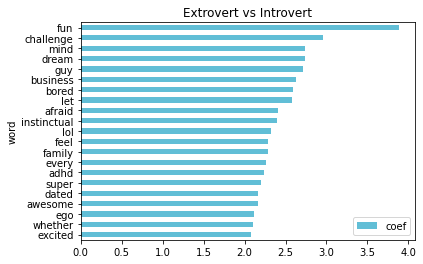

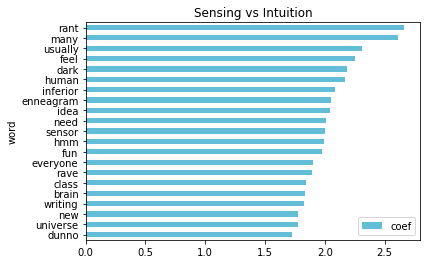

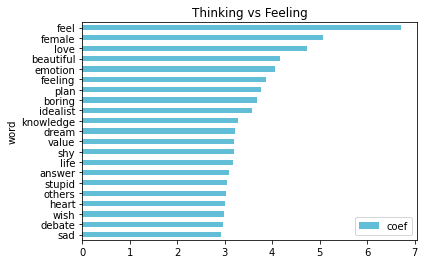

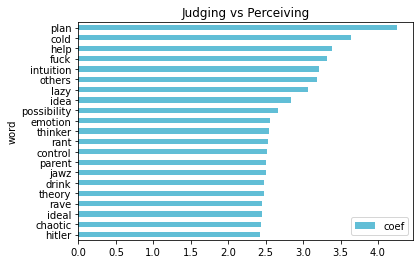

<IPython.core.display.Javascript object>

In [21]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_['tfidf'].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=['word', 'coef']).set_index('word')    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")